# Running the ICML 2018 Experiments

In this series of notebooks, we will replicate and analyze the ICML 2018 experiments that where used for benchmarking in <a href="http://proceedings.mlr.press/v80/falkner18a.html" target="_blank">BOHB (Falkner et al. 2018)</a>.
In addition to <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a>, we will use <a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> to analyze and visualize the optimization process.

## About the frameworks

### Cartpole

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center." (<a href="https://gym.openai.com/envs/CartPole-v0/" target="_blank">openAI gym description</a>)

### Installation requirements

To run the experiments, please install the <a href="https://github.com/automl/BOHBsCAVE/blob/master/examples/icml_2018_experiments/requirements.txt" target="_blank">requirements</a>, e.g. `pip install -r examples/icml_2018_experiments/requirements.txt`.

## Run the experiment


In [ ]:
# We deactivate logging to ensure readability
import logging
logging.basicConfig(level=logging.ERROR)
# Also, we suppress warnings.
# If there are problems for you executing this notebook, you might want to comment this out.
import warnings
warnings.filterwarnings("ignore")

### 1.1) References
*Worker*: We need a <a href="https://automl.github.io/HpBandSter/build/html/core/worker.html" target="_blank">Worker</a> to define the kind of computation we want to optimize. The worker used for the experiments is located in `workers/cartpole_worker.py`



*ConfigSpace*: Every problem needs a description of the search space to be complete. In HpBandSter, a <a href="https://github.com/automl/ConfigSpace/tree/master/ConfigSpace" target="_blank">ConfigurationSpace</a>-object defines all hyperparameters, their ranges and dependencies between them.

In our example here, the search space consists of the hyperparameters:
                                  

|  Name                     |  Type   |      Values      |
|:-------------------------:|:-------:|:----------------:|
| batch_size                | integer | [8, 256] log     |
| discount                  | real    | [0.0, 1.0]       |
| entropy_regularization    | real    | [0.0, 1.0]       |
| learning_rate             | real    | [1e-07, 0.1] log |
| likelihood_ratio_clipping | real    | [0.0, 1.0]       |
| n_units_1                 | float   | [8, 128]         |
| n_units_2                 | float   | [8, 1<28]        |

### 1.3) Setting up the experiment and running the optimizer(s)

Please note that the execution of the experiment with all datasets might take up to a few days, depending on your hardware. You can also skip this step and process with the precomputed results saved in `opt_results/cartpole`.

In [ ]:
import os
from itertools import product
import numpy as np

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB, RandomSearch, HyperBand

from workers.cartpole_worker import CartpoleReducedWorker

# Run the experiment, evaluate each dataset on each optimizer

datasets =  ['toyfunction', 'bostonhousing', 'proteinstructure']
opt_methods = ["smac", "bohb", "randomsearch", "hyperband"]
num_iterations = 4
min_budget = 300
max_budget = 10000

eta = 3

for dataset, opt_method in product(datasets, opt_methods):

    print(dataset, opt_method)
    
    output_dir = "opt_results/bnn/{}/{}".format(dataset, opt_method)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    run_id = '0'  # Every run has to have a unique (at runtime) id.
    
    # create a worker
    worker = BNNWorker(dataset=dataset, measure_test_loss=False, run_id=run_id, max_budget=max_budget)
    configspace = worker.configspace

    if opt_method in ['randomsearch', 'bohb', 'hyperband']:
        # setup a nameserver
        NS = hpns.NameServer(run_id=run_id, host='localhost', port=0, working_directory=output_dir)
        ns_host, ns_port = NS.start()

        worker.load_nameserver_credentials(output_dir)
        worker.run(background=True)

        # instantiate and run optimizer
        opt = RandomSearch if opt_method == 'randomsearch' else BOHB if opt_method == 'bohb' else HyperBand

        result_logger = hpres.json_result_logger(directory=output_dir, overwrite=True)

        opt = opt(configspace, eta=3,
                  working_directory=output_dir,
                  run_id=run_id,
                  min_budget=min_budget, max_budget=max_budget,
                  host=ns_host,
                  nameserver=ns_host,
                  nameserver_port = ns_port,
                  ping_interval=3600,
                  result_logger=result_logger)

        result = opt.run(n_iterations=num_iterations)
            
        # **NOTE:** Unfortunately, the configuration space is *not yet saved automatically* to file
        # but this step is mandatory for the analysis with CAVE.  
        # We recommend to save the configuration space every time you use BOHB.
        # We do this by using the ConfigSpace-to-json-writer.

        from ConfigSpace.read_and_write import pcs_new
        with open(os.path.join(output_dir, 'configspace.pcs'), 'w') as fh:
            fh.write(pcs_new.write(opt.config_generator.configspace))
    
    else:
        # the number of iterations for the blackbox optimizers must be increased so they have comparable total budgets
        bb_iterations = int(num_iterations * (1+(np.log(max_budget) - np.log(min_budget))/np.log(eta)))
        if opt_method == 'smac':
            result = worker.run_smac(bb_iterations, deterministic=True, working_directory=output_dir)

## Using the results in CAVE

### Instantiate CAVE

Analyzing the optimization results with CAVE is very straight-forward. If you want to use CAVE interactively in a notebook, set `show_jupyter=True`. Specify which optimization you want to analyze via the `folders` argument and specify `file_format==SMAC3` or `file_format==BOHB`, depending on which optimizer was used for the results. To analyze how BOHB optimized the cartpole-problem, run:

In [2]:
from cave.cavefacade import CAVE

cave = CAVE(folders=["opt_results/cart/bohb"],  # .../bnn/DATASET/OPTIMIZER
            output_dir="CAVE_reports/bnn_notebook",          # output for debug/images/etc
            ta_exec_dir=["."],                               # Only important for SMAC-results
            file_format='BOHB',                              # BOHB or SMAC3
            verbose_level='OFF',
            show_jupyter=True,
           )

To generate the HTML-report you can use the `analyze`-method. The report is located in `output_dir/report.html`, so in this case in `CAVE_reports/bnn_notebook/report.html`.

In [3]:
cave.analyze()
! firefox CAVE_reports/bnn_notebook/report.html

/home/shuki/Repos/BOHBsCAVE/.ve_BOHBsCAVE/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


CAVE is fully compatible with Jupyter notebooks. You can invoke the individual analysis methods as follows.

The most interesting plot for BOHB might be a visualization of the learning curves:

In [16]:
cave.bohb_learning_curves();

Loading BokehJS ...

In [17]:
cave.overview_table();

For each budget, we can list the cost over incumbents:

In [19]:
cave.bohb_incumbents_per_budget();

,budget 370.4,budget 1111.1,budget 3333.3,budget 10000
burn_in,0.389664,0.0537928,0.0537928,0.0537928
l_rate,0.0297414,0.0695345,0.0695345,0.0695345
mdecay,0.328801,0.586302,0.586302,0.586302
n_units_1,67,228,228,228
n_units_2,184,24,24,24
Cost,39.162,5.413,5.851,4.992


For parameter-importance analysis, CAVE uses <a href="https://github.com/automl/ParameterImportance" target="_blank">PIMP</a> , a package that provides multiple approaches to parameter-importance analysis. We can easily invoke them via CAVE, of course. To estimate the importance, random forests are used to predict performances of configurations that were not executed. This is difficult for big budgets with few configurations.

We can access the individual budgets via the 'run'-keyword-argument of each analysis-method.

In [20]:
cave.cave_fanova(run='budget_10000');

-------------------- Single importance: --------------------,--------------------
l_rate,59.6515 +/- 46.4956
burn_in,28.4864 +/- 43.246
mdecay,7.1975 +/- 24.2353
n_units_2,1.3038 +/- 3.8476
n_units_1,0.4141 +/- 1.579
-------------------- Pairwise importance: --------------------,--------------------
burn_in & mdecay,1.9159 +/- 7.4185
l_rate & n_units_2,0.6959 +/- 1.8439
l_rate & n_units_1,0.2079 +/- 0.7715
l_rate & burn_in,0.1036 +/- 0.2745


In [21]:
cave.local_parameter_importance(run='budget_10000');

For each budget, we can compare the different parameter-importance-methods that have already been run:

In [15]:
cave.pimp_comparison_table(run='budget_10000');

Loading BokehJS ...

To analyze BOHB's behaviour, we can check out the configurator footprint, cost-over-time and parallel coordinated parameters:

In [22]:
cave.configurator_footprint(use_timeslider=True, num_quantiles=5);

Loading BokehJS ...

In [23]:
cave.cost_over_time();

Loading BokehJS ...

/home/shuki/Repos/BOHBsCAVE/.ve_BOHBsCAVE/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


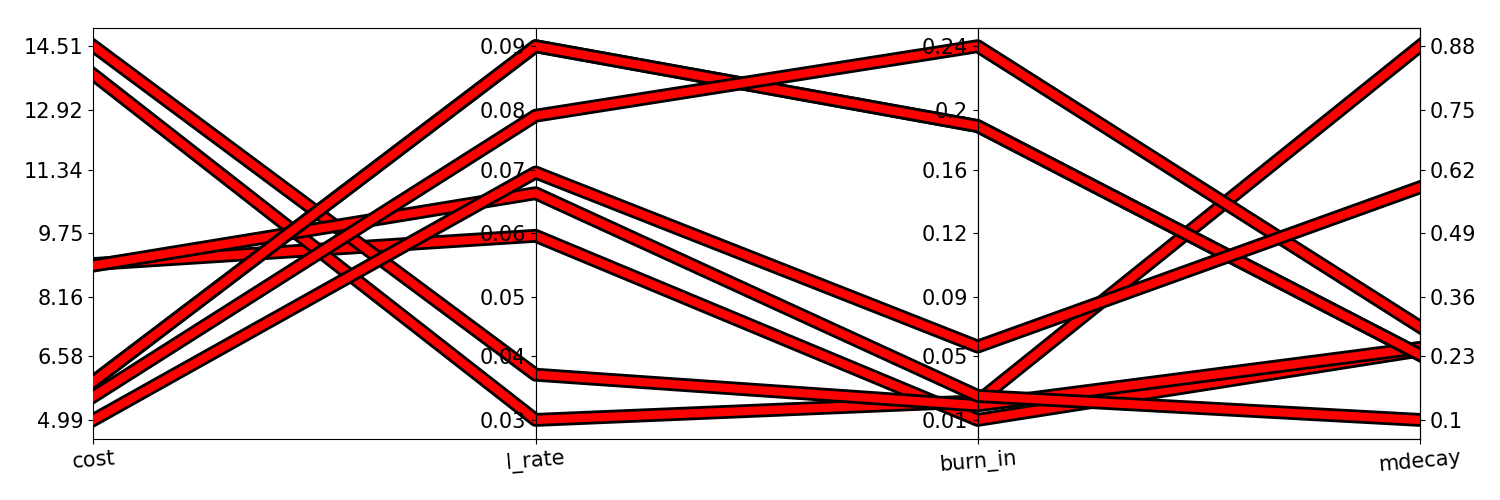

In [24]:
cave.parallel_coordinates(run='budget_10000');